### **Benchmark Visualization**

Necessary folder structure to run this code:

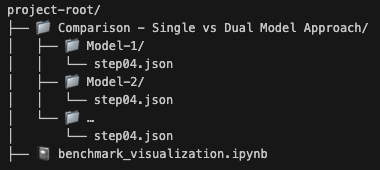

The step04.json is the result of running benchmark_execution.ipynb.

**1.) Visualizing Asset Placement Accuracy**

In [ ]:
import json
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def move_somewhere_to_end(df):
    """Reorders dataframe columns so that 'somewhere' is last."""
    cols = list(df.columns)
    if "somewhere" in cols:
        cols = [c for c in cols if c != "somewhere"] + ["somewhere"]
    return df[cols]


def load_step_data(parent_dir):
    """Loads all step04.json files from subdirectories into a dictionary of DataFrames."""
    data = {}
    for subdir in Path(parent_dir).iterdir():
        step_file = subdir / "step04.json"
        if step_file.exists():
            with open(step_file, "r", encoding="utf-8") as f:
                data[subdir.name] = pd.DataFrame(json.load(f))
    return data


def compute_metrics(step_data):
    """Computes room-level and asset-level metrics across steps."""
    valid_percentages = {}
    missing_dist = {}
    over_dist = {}
    missing_by_room = {}
    over_by_room = {}

    for step, df in step_data.items():
        if df.empty:
            continue

        df_filtered = df[df["assets"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
        if df_filtered.empty:
            continue

        total = len(df_filtered)

        no_missing = df_filtered["items_missing"].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
        no_over = df_filtered["items_over"].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
        both_ok = df_filtered[(df_filtered["items_missing"].apply(lambda x: len(x) == 0)) &
                              (df_filtered["items_over"].apply(lambda x: len(x) == 0))].shape[0]

        valid_percentages[step] = {
            "No Missing Assets": 100 * no_missing / total,
            "No Over-Predicted \n Assets": 100 * no_over / total,
            "No Missing or \n Over-Predicted Assets": 100 * both_ok / total
        }

        missing_dist[step] = df_filtered["items_missing"].apply(lambda x: len(x) if isinstance(x, list) else 0).value_counts(normalize=True).sort_index()
        over_dist[step] = df_filtered["items_over"].apply(lambda x: len(x) if isinstance(x, list) else 0).value_counts(normalize=True).sort_index()

        # Room-level error analysis
        all_rooms = df_filtered["assets"].explode().dropna().apply(lambda x: x[0].lower() if isinstance(x, list) and len(x) > 1 else None).value_counts()
        miss = df_filtered["items_missing"].explode().dropna().apply(lambda x: x[0].lower()).value_counts()
        over = df_filtered["items_over"].explode().dropna().apply(lambda x: x[0].lower()).value_counts()

        missing_by_room[step] = {room: (miss.get(room, 0) / all_rooms[room]) * 100 for room in all_rooms.index}
        over_by_room[step] = {room: (over.get(room, 0) / all_rooms[room]) * 100 for room in all_rooms.index}

    return valid_percentages, missing_dist, over_dist, missing_by_room, over_by_room


def prepare_dataframes(valid_percentages, missing_by_room, over_by_room):
    """Creates dataframes for plotting."""
    valid_df = pd.DataFrame(valid_percentages).T.fillna(0).sort_index()
    missing_df = pd.DataFrame(missing_by_room).T.fillna(0)
    over_df = pd.DataFrame(over_by_room).T.fillna(0)

    all_columns = sorted(set(missing_df.columns).union(over_df.columns))
    missing_df = move_somewhere_to_end(missing_df.reindex(columns=all_columns))
    over_df = move_somewhere_to_end(over_df.reindex(columns=all_columns))

    return valid_df, missing_df, over_df


def plot_comparison(valid_df, missing_df, over_df, missing_dist, over_dist):
    """Generates five subplots comparing system performance across multiple steps."""
    steps = valid_df.index.tolist()
    colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
    color_map = dict(zip(steps, colors))
    width = 0.15

    fig, axarr = plt.subplots(3, 2, figsize=(14, 15), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1, 1]})
    axes = [axarr[0, 0], axarr[1, 0], axarr[1, 1], axarr[2, 0], axarr[2, 1]]
    legend_ax = axarr[0, 1]
    legend_ax.axis("off")

    # Plot 1: Valid entry percentages
    x = np.arange(len(valid_df.columns))
    for i, step in enumerate(steps):
        axes[0].bar(x + i * width, valid_df.loc[step], width=width, label=step, color=color_map[step], edgecolor='black')
    axes[0].set_xticks(x + width * (len(steps) - 1) / 2)
    axes[0].set_xticklabels(valid_df.columns, rotation=15, fontsize=16)
    axes[0].set_ylabel("Percentage of Entries(%)", fontsize=16)
    axes[0].set_title("Entries with Correct Asset Placements", fontsize=18, pad=20)
    axes[0].tick_params(axis='y', labelsize=16)
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # Plot 2: Missing items by room type
    x = np.arange(len(missing_df.columns))
    for i, step in enumerate(steps):
        axes[1].bar(x + i * width, missing_df.loc[step], width=width, color=color_map[step], edgecolor='black')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(missing_df.columns, rotation=30, ha="right", fontsize=16)
    axes[1].set_ylabel("Error Rate (%)", fontsize=16)
    axes[1].set_title("Missing Assets by Room Type", fontsize=18, pad=20)
    axes[1].tick_params(axis='y', labelsize=16)
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)

    # Plot 3: Over items by room type
    x = np.arange(len(over_df.columns))
    for i, step in enumerate(steps):
        axes[2].bar(x + i * width, over_df.loc[step], width=width, color=color_map[step], edgecolor='black')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(over_df.columns, rotation=30, ha="right", fontsize=16)
    axes[2].set_ylabel("Error Rate (%)", fontsize=16)
    axes[2].set_title("Over-Predicted Assets by Room Type", fontsize=18, pad=20)
    axes[2].tick_params(axis='y', labelsize=16)
    axes[2].grid(axis='y', linestyle='--', alpha=0.5)

    # Plot 4: Distribution of Missing Assets per entry
    x_labels = sorted(set().union(*[dist.index for dist in missing_dist.values()]))
    x = np.arange(len(x_labels))
    for i, step in enumerate(steps):
        y = [missing_dist[step].get(val, 0) for val in x_labels]
        axes[3].bar(x + i * width, y, width=width, color=color_map[step], edgecolor='black')
    axes[3].set_xticks(x + width * (len(steps) - 1) / 2)
    axes[3].set_xticklabels(x_labels, fontsize=16)
    axes[3].set_ylabel("Relative Frequency (%)", fontsize=16)
    axes[3].set_title("Missing Assets per Entry", fontsize=18, pad=20)
    axes[3].set_xlabel("Number of Missing Assets", fontsize=16)
    axes[3].tick_params(axis='y', labelsize=16)
    axes[3].grid(axis='y', linestyle='--', alpha=0.5)

    # Plot 5: Distribution of Over Assets per entry
    x_labels = sorted(set().union(*[dist.index for dist in over_dist.values()]))
    x = np.arange(len(x_labels))
    for i, step in enumerate(steps):
        y = [over_dist[step].get(val, 0) for val in x_labels]
        axes[4].bar(x + i * width, y, width=width, color=color_map[step], edgecolor='black')
    axes[4].set_xticks(x + width * (len(steps) - 1) / 2)
    axes[4].set_xticklabels(x_labels, fontsize=16)
    axes[4].set_ylabel("Relative Frequency (%)", fontsize=16)
    axes[4].set_title("Distribution of Over Items", fontsize=18, pad=20)
    axes[4].set_xlabel("Number of Over-Predicted Assets", fontsize=16)
    axes[4].tick_params(axis='y', labelsize=16)
    axes[4].grid(axis='y', linestyle='--', alpha=0.5)

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    # label_map = {
    #     "LM-Layouts + LM-Placements-V3": "Two-Model System",
    #     "LM-Mono": "Single-Model System"
    # }
    # labels = [label_map.get(label, label) for label in labels]
    legend_ax.legend(handles, labels, title="System Configuration", fontsize=16, title_fontsize=16, loc='center', frameon=True)

    # Final layout
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.tight_layout()
    plt.show()


# === Entry Point ===
PARENT_DIR = "MAIN FOLDER"

step_data = load_step_data(PARENT_DIR)
valid, missing_dist, over_dist, missing_by_room, over_by_room = compute_metrics(step_data)
valid_df, missing_df, over_df = prepare_dataframes(valid, missing_by_room, over_by_room)
plot_comparison(valid_df, missing_df, over_df, missing_dist, over_dist)

**2.) Visualizing Room Generation Accuracy**

In [ ]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


def load_step04_data(directory):
    """Loads step04.json data from the given subdirectory."""
    path = directory / "step04.json"
    if path.exists():
        with open(path, "r", encoding="utf-8") as file:
            return json.load(file)
    return None


def gather_all_data(parent_path):
    """Loads step04.json files from all subdirectories."""
    step_data = {}
    for subdir in parent_path.iterdir():
        if subdir.is_dir():
            data = load_step04_data(subdir)
            if data:
                step_data[subdir.name] = pd.DataFrame(data)
    return step_data


def analyze_missing_rooms(step_data):
    """Computes missing room statistics for each dataset."""
    rooms_missing_percentage = {}
    room_occurrences = {}

    for step, df in step_data.items():
        if df.empty:
            continue

        df_filtered = df[df["include_rooms"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
        total = len(df_filtered)
        if total == 0:
            continue

        no_missing = df_filtered["rooms_missing"].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
        rooms_missing_percentage[step] = (no_missing / total) * 100

        room_counts = {}
        for rooms in df_filtered["rooms_missing"].dropna():
            for room in set(rooms):
                room_counts[room] = room_counts.get(room, 0) + 1

        room_occurrences[step] = {room: (count / total) * 100 for room, count in room_counts.items()}

    return rooms_missing_percentage, room_occurrences


def plot_statistics(rooms_missing_df, room_occurrences_df):
    """Plots missing room statistics and per-room breakdowns."""
    steps = rooms_missing_df.index.tolist()
    colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
    color_mapping = dict(zip(steps, colors))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10),
                             gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
    ax1 = axes[0, 0]
    ax2 = axes[1, 0]

    fig.delaxes(axes[0, 1])
    fig.delaxes(axes[1, 1])

    # Plot 1: Overall room inclusion
    x = np.array([0])
    width = 0.3

    for i, step in enumerate(steps):
        bars = ax1.bar(
            x + i * width - (len(steps) - 1) * width / 2,
            rooms_missing_df.loc[step, "No Missing Rooms"],
            width=width,
            color=color_mapping[step],
            edgecolor="black",
            label=step
        )
        for bar in bars:
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                height + 1,
                f"{height:.1f}%",
                ha="center",
                fontsize=16
            )

    ax1.set_xticks([0])
    ax1.set_xticklabels(["No Missing Rooms"], fontsize=16)
    ax1.set_ylabel("Percentage of Entries (%)", fontsize=16)
    ax1.set_ylim(0, 110)
    ax1.set_title("Entries Including All Requested Rooms", fontsize=18, pad=20)
    ax1.tick_params(axis="y", labelsize=16)
    ax1.grid(axis="y", linestyle="--", alpha=0.5)

    # Plot 2: Missing rooms by type
    room_types = room_occurrences_df.columns
    x = np.arange(len(room_types))
    width = 0.1

    for i, step in enumerate(steps):
        ax2.bar(
            x + i * width,
            room_occurrences_df.loc[step],
            width=width,
            color=color_mapping[step],
            edgecolor="black"
        )

    ax2.set_ylabel("Missing Rooms (%)", fontsize=16)
    ax2.set_title("Missing Requested Rooms by Room Type", fontsize=18, pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(room_types, rotation=30, ha="right", fontsize=16)
    ax2.tick_params(axis="y", labelsize=16)
    ax2.grid(axis="y", linestyle="--", alpha=0.5)

    # Legend
    handles, labels = ax1.get_legend_handles_labels()
    # label_map = {
    #     "LM-Layouts + LM-Placements-V3": "Two-Model System",
    #     "LM-Mono": "Single-Model System"
    # }
    # labels = [label_map.get(label, label) for label in labels]
    fig.legend(
        handles, labels,
        title="System Configuration",
        fontsize=16,
        title_fontsize=16,
        loc="center",
        frameon=True,
        bbox_to_anchor=(0.75, 0.75),
        bbox_transform=fig.transFigure
    )

    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    plt.tight_layout()
    plt.show()
    print("Visualization updated successfully: Font sizes adjusted for consistency.")


def process_comparison_visualization(parent_folder):
    """Runs the full comparison visualization pipeline."""
    parent_path = Path(parent_folder)
    step_data = gather_all_data(parent_path)
    rooms_missing, room_occurrences = analyze_missing_rooms(step_data)

    rooms_missing_df = pd.DataFrame.from_dict(
        rooms_missing, orient="index", columns=["No Missing Rooms"]
    ).fillna(0).sort_index()

    room_occurrences_df = pd.DataFrame(room_occurrences).fillna(0).T
    plot_statistics(rooms_missing_df, room_occurrences_df)


# === Run ===
PARENT_DIR = "MAIN FOLDER"
process_comparison_visualization(PARENT_DIR)

**3.) Visualizing Connection Generation Accuracy**

In [ ]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


def load_step04_data(directory):
    """Loads step04.json from a directory if it exists."""
    file_path = directory / "step04.json"
    if file_path.exists():
        with open(file_path, "r", encoding="utf-8") as file:
            return json.load(file)
    return None


def collect_step_data(parent_dir):
    """Collects and returns all non-empty DataFrames from step folders."""
    step_data = {}
    for subdir in parent_dir.iterdir():
        if subdir.is_dir():
            data = load_step04_data(subdir)
            if data:
                df = pd.DataFrame(data)
                if not df.empty:
                    step_data[subdir.name] = df
    return step_data


def compute_metrics(step_data):
    """Calculates connection accuracy and type matching metrics."""
    connections_missing_percentage = {}
    connection_type_correct_percentage = {}
    connection_type_accuracy = {}

    for step, df in step_data.items():
        df_filtered = df[df["include_connections"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
        if len(df_filtered) == 0:
            continue

        no_missing = df_filtered["connections_missing"].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
        connections_missing_percentage[step] = (no_missing / len(df_filtered)) * 100

        total = len(df)
        correct_type = df["connection_type_correct"].sum()
        connection_type_correct_percentage[step] = (correct_type / total) * 100

        df["normalized_connection_type"] = df["connection_type"].apply(
            lambda x: "central to ANY" if x == "central to ANY"
            else ("central to <room type>" if isinstance(x, str) and x.startswith("central to") else x)
        )

        counts = df["normalized_connection_type"].value_counts()
        correct_counts = df[df["connection_type_correct"] == True]["normalized_connection_type"].value_counts()

        connection_type_accuracy[step] = {
            conn_type: (correct_counts.get(conn_type, 0) / count) * 100
            for conn_type, count in counts.items()
        }

    return connections_missing_percentage, connection_type_correct_percentage, connection_type_accuracy


def build_metric_frames(missing, correct, accuracy):
    """Builds pandas DataFrames from collected metric dictionaries."""
    missing_df = pd.DataFrame.from_dict(missing, orient="index", columns=["No Missing Connections"]).fillna(0).sort_index()
    correct_df = pd.DataFrame.from_dict(correct, orient="index", columns=["Correct Connection Type (%)"]).fillna(0).sort_index()
    accuracy_df = pd.DataFrame(accuracy).fillna(0).T

    if "other" in accuracy_df.columns:
        accuracy_df = accuracy_df.drop(columns=["other"])

    return missing_df, correct_df, accuracy_df


def plot_metrics(missing_df, correct_df, accuracy_df):
    """Generates the comparison plots."""
    steps = missing_df.index.tolist()
    colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
    color_map = {step: color for step, color in zip(steps, colors)}

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1, 1]})
    axes = [axes[0, 0], axes[1, 0], axes[1, 1]]

    x = np.array([0])
    width = 0.3

    # === Plot 1: No Missing Connections ===
    for i, step in enumerate(steps):
        bar = axes[0].bar(
            x + i * width - (len(steps) - 1) * width / 2,
            missing_df.loc[step, "No Missing Connections"],
            width=width,
            label=step,
            color=color_map[step],
            edgecolor='black'
        )
        for b in bar:
            height = b.get_height()
            axes[0].text(b.get_x() + b.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', fontsize=16)

    axes[0].set_xticks([0])
    axes[0].set_xticklabels(["No Missing Connections"], fontsize=16)
    axes[0].set_ylabel("Percentage of Entries (%)", fontsize=16)
    axes[0].set_title("Entries Including All Requested Connections", fontsize=18, pad=15)
    axes[0].tick_params(axis='y', labelsize=16)
    axes[0].set_ylim(0, 110)
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # === Plot 2: Correct Connection Type ===
    for i, step in enumerate(steps):
        bar = axes[1].bar(
            x + i * width - (len(steps) - 1) * width / 2,
            correct_df.loc[step, "Correct Connection Type (%)"],
            width=width,
            label=step,
            color=color_map[step],
            edgecolor='black'
        )
        for b in bar:
            height = b.get_height()
            axes[1].text(b.get_x() + b.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', fontsize=16)

    axes[1].set_xticks([0])
    axes[1].set_xticklabels(["Correct Connection Type"], fontsize=16)
    axes[1].set_ylabel("Percentage of Entries (%)", fontsize=16)
    axes[1].set_title("Entries with Correct Connection Type", fontsize=18, pad=15)
    axes[1].tick_params(axis='y', labelsize=16)
    axes[1].set_ylim(0, 110)
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)

    # === Plot 3: Accuracy per Connection Type ===
    x = np.arange(len(accuracy_df.columns))
    width = 0.1
    for i, step in enumerate(steps):
        axes[2].bar(
            x + i * width,
            accuracy_df.loc[step],
            width=width,
            color=color_map[step],
            edgecolor='black'
        )

    axes[2].set_ylabel("Correct Connection Type (%)", fontsize=16)
    axes[2].set_title("Accuracy by Connection Type", fontsize=18)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(accuracy_df.columns, rotation=30, ha="right", fontsize=16)
    axes[2].tick_params(axis='y', labelsize=16)
    axes[2].set_ylim(0, 110)
    axes[2].grid(axis='y', linestyle='--', alpha=0.5)

    # Legend
    fig.delaxes(fig.axes[1])
    handles, labels = axes[0].get_legend_handles_labels()
    label_map = {
        "LM-Layouts + LM-Placements-V3": "Two-Model System",
        "LM-Mono": "Single-Model System"
    }
    labels = [label_map.get(label, label) for label in labels]
    fig.legend(
        handles,
        labels,
        title="System Configuration",
        fontsize=16,
        title_fontsize=16,
        loc="center",
        frameon=True,
        bbox_to_anchor=(0.75, 0.75),
        bbox_transform=fig.transFigure
    )

    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    plt.tight_layout()
    plt.show()


# === Entry Point ===
PARENT_DIR = Path("Comparison - Single vs Dual Model Approach")
step_data = collect_step_data(PARENT_DIR)

missing, correct, accuracy = compute_metrics(step_data)
missing_df, correct_df, accuracy_df = build_metric_frames(missing, correct, accuracy)

plot_metrics(missing_df, correct_df, accuracy_df)